In [45]:
import numpy as np
import pandas as pd
import nltk 
import matplotlib.pyplot as plt
from nltk import pos_tag
from sklearn import model_selection, preprocessing,metrics,naive_bayes,svm
from nltk.tokenize import word_tokenize
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import os
import random
from nltk.corpus import wordnet as wn

### labeling the text 

In [37]:
path = r"C:\Users\harshavb\Desktop\xlabs\imdb-movie-reviews-dataset\aclImdb"
# positiveFiles = [x for x in os.listdir(path+"train\pos") if x.endswith(".txt")]
# negativeFiles = [x for x in os.listdir(path+"train\neg") if x.endswith(".txt")]
# testFiles = [x for x in os.listdir(path+"test") if x.endswith(".txt")]
train_texts = []
train_labels = []
for category in ['pos', 'neg']:
    train_path = os.path.join(path, 'train', category)
    for fname in sorted(os.listdir(train_path)):
        if fname.endswith('.txt'):
            with open(os.path.join(train_path, fname),encoding="utf8") as f:
                train_texts.append(f.read())
            train_labels.append(0 if category == 'neg' else 1)
test_texts = []
test_labels = []
for category in ['pos', 'neg']:
    test_path = os.path.join(path, 'test', category)
    for fname in sorted(os.listdir(test_path)):
        if fname.endswith('.txt'):
            with open(os.path.join(test_path, fname),encoding="utf8") as f:
                test_texts.append(f.read())
            test_labels.append(0 if category == 'neg' else 1)

seed=123
random.seed(seed)
random.shuffle(train_texts)
random.seed(seed)
random.shuffle(train_labels)
random.seed(seed)
random.shuffle(test_texts)
random.seed(seed)
random.shuffle(test_labels)

### converting in to dataframe

In [38]:
train=pd.DataFrame({"review":train_texts, "label":train_labels},columns=['review','label'] )
test=pd.DataFrame({"review":test_texts, "label":test_labels},columns=['review','label'] )
X_train=train['review']
y_train=train['label']
Xtest=test['review']
y_test=test['label']
X_train=X_train.apply(word_tokenize)
X_test=Xtest.apply(word_tokenize)

In [43]:
size_of_samp = 5
trX=train['review']
trY=train['label']
rand_samples_to_check = np.random.randint(len(trX), size=size_of_samp)

for samp_num in rand_samples_to_check:
    print ('============================================================')
    print (trX[samp_num], '||', trY[samp_num])
    print ('============================================================')

Luchino Visconti was light years ahead of his contemporaries. The great directors of Italy of the 40s and 50s were men who understood the medium, but it was Luchino Visconti, a man of vision, who dared to bring a film like to show what he was capable of doing. He clearly shows his genius early on in his distinguished career with "Ossessione", a film based on James Cain's "The Postman Always Ring Twice", which was later made by Hollywood, but that version pales in comparison with what Visconti achieved in the movie. Luchino Visconti and his collaborators on the screen included an uncredited Alberto Moravia, a man who knew about the effect of passion on human beings.<br /><br />The film has been well preserved in the DVD format we watched recently. The film is a must for all serious movie fans because we can see how Visconti's vision translated the text into a movie that rings true in a plausible way, something the American version lacked.<br /><br />What comes across watching the movie,

### visualization of frequency of the words

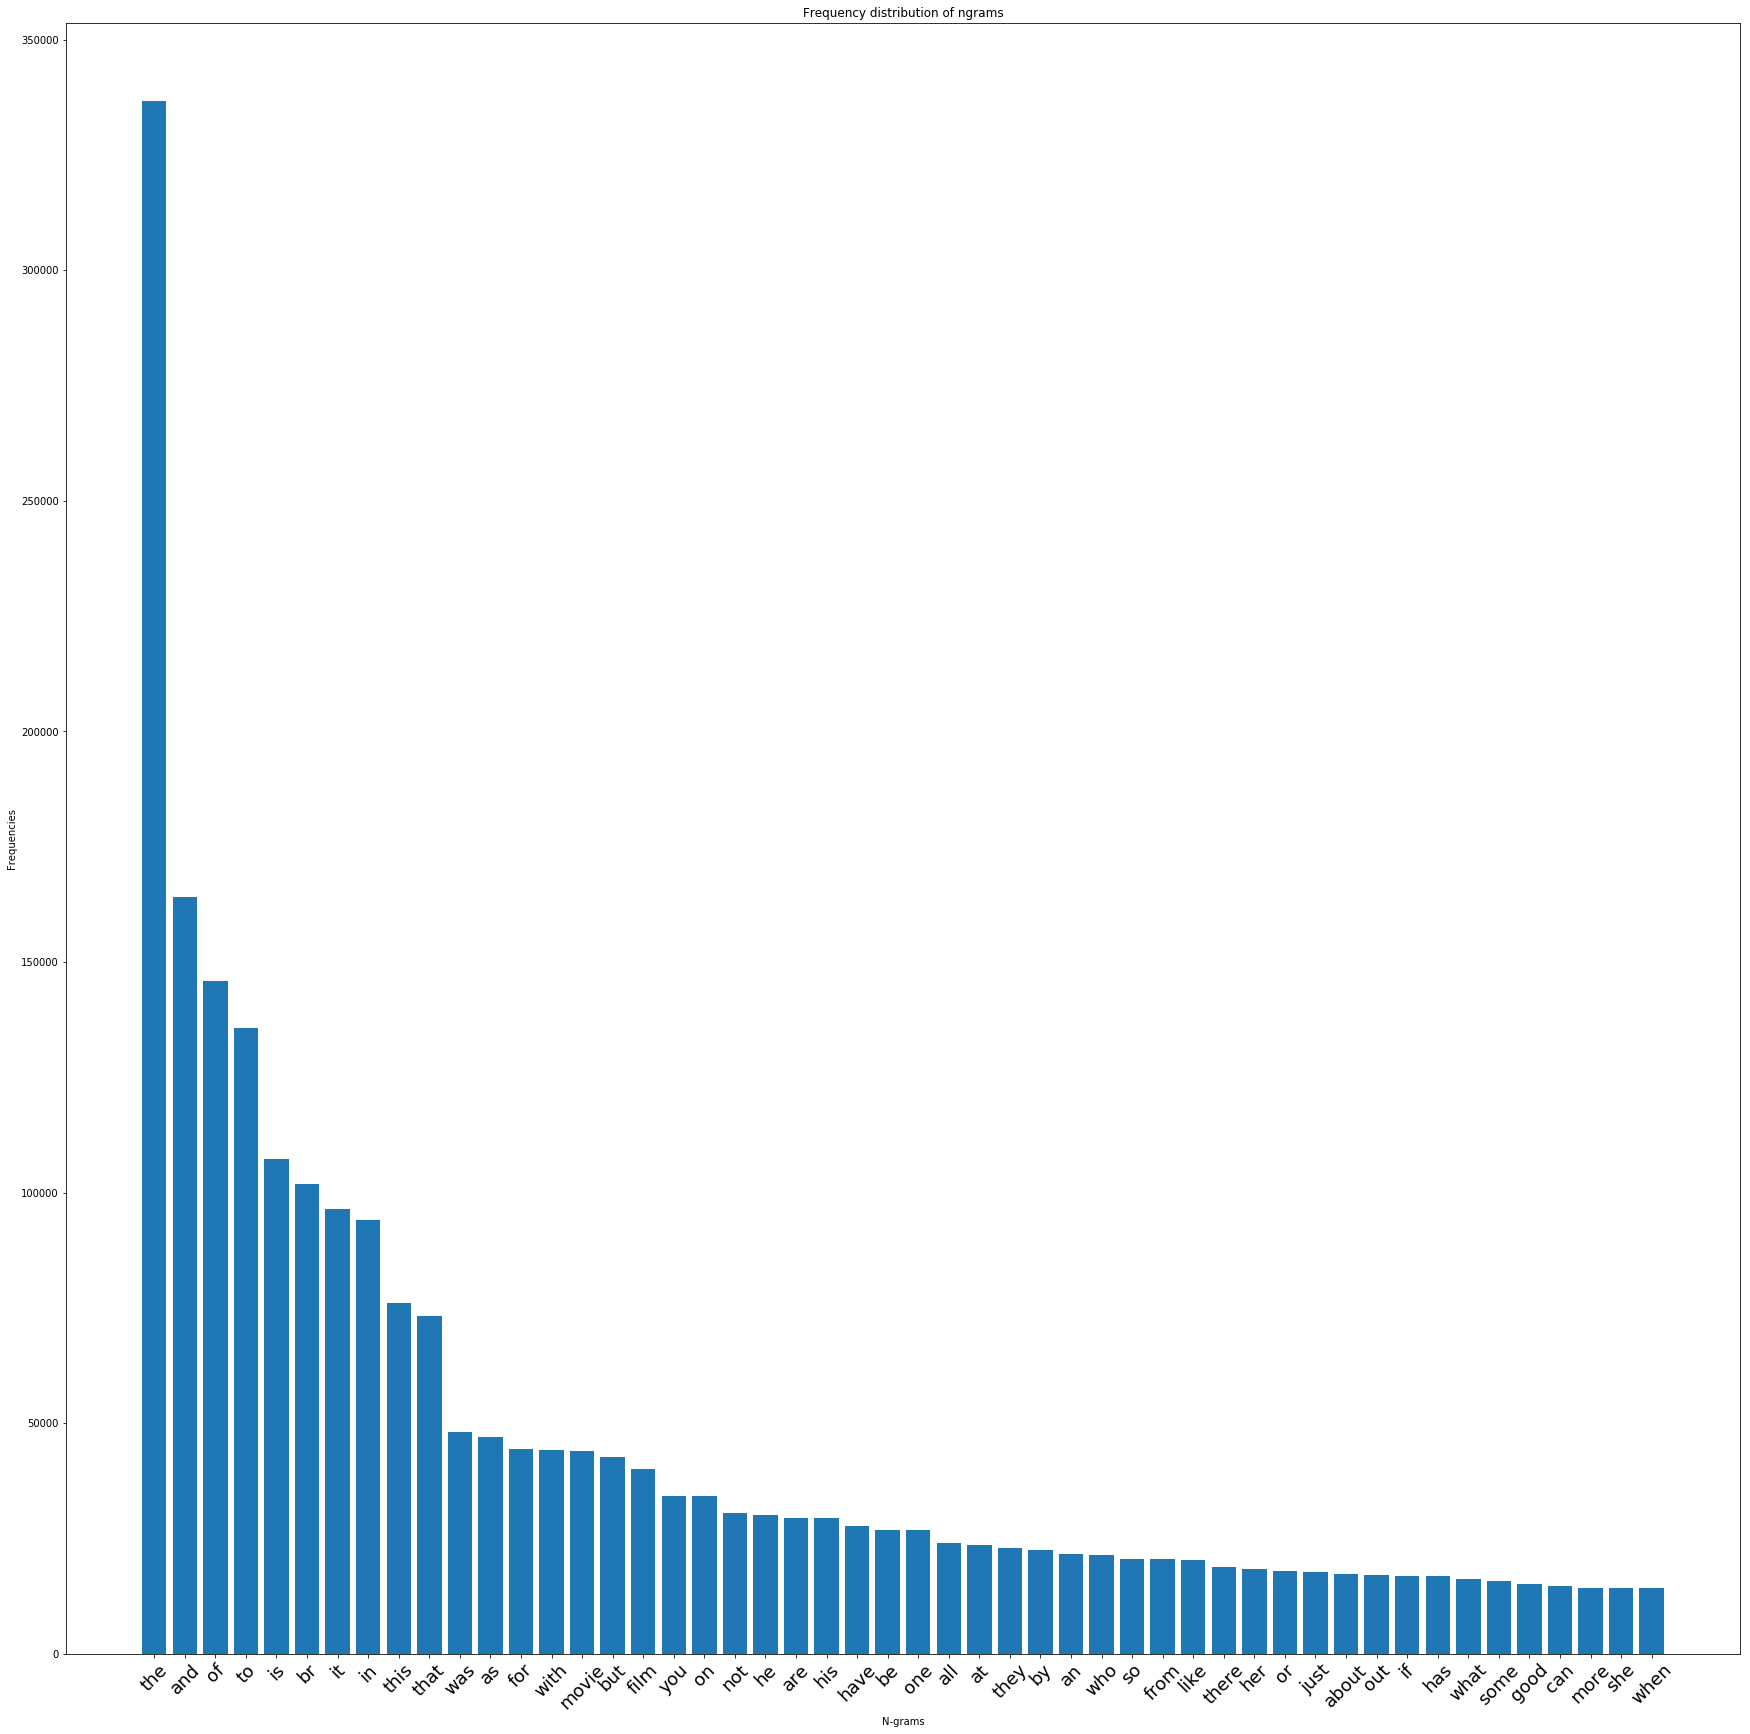

In [46]:
kwargs = {
    'ngram_range' : (1, 1),
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : 'word'
}

vectorizer = CountVectorizer(**kwargs)
vect_texts = vectorizer.fit_transform(list(trX))
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45,fontsize=18)
plt.show()

### Stop words

In [48]:
from string import punctuation
words = ['br','The','I','Her','i', 'me', 'my', 'myself', 'we', 'our', 'ours','"','"','ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the']
stopwords = set(stopwords.words('german')+list(punctuation)+list(words))

### preprocessing the data 

In [49]:
trainp=train
testp=test
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(X_train):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words
        if word not in stopwords :
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    trainp.loc[index,'text_final'] = str(Final_words)

In [50]:
for index,entry in enumerate(X_test):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords:
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    testp.loc[index,'text_final'] = str(Final_words)

### Tf-Idf vectorizer

In [103]:
#NGRAM_RANGE = (1, 2)
#using tfidf
vectorizer = TfidfVectorizer(decode_error='replace',
                             strip_accents='unicode',
                             analyzer='word',stop_words=None,token_pattern=r'\w{1,}',
                             ngram_range=(1, 2), max_df=1.0, min_df=2,lowercase=True)

### training the model without preprocessing of text

In [84]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainp['review'], trainp['label'],test_size=0.3)
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
train_x=vectorizer.fit_transform(train_x)
valid_x=vectorizer.transform(valid_x)
test_y = encoder.fit_transform(y_test)
X_test=test['text_final'] #pre-processed test data
test_wp=test['review'] #without preprocessing

In [85]:
xtest_tfi =  vectorizer.transform(X_test)#tfidf vectorizer on pre-processed text
test_pvect= vectorizer.transform(test_wp)#tfidf vectorizer on text without preprocessing

### using different types of model and finding the accuracy comparing the accuracy between processed and normal data

In [87]:
from sklearn.naive_bayes import BernoulliNB
classifier=BernoulliNB().fit(train_x,train_y)
predictions = classifier.predict(valid_x)
print("valid:",metrics.accuracy_score(predictions, valid_y))

predict_test = classifier.predict(xtest_tfi)
predict_testwp = classifier.predict(test_pvect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

valid: 0.8704
test_Processing: 0.85324
test_withoutprocess : 0.86036


In [88]:
bayes_class=naive_bayes.MultinomialNB().fit(train_x,train_y)
predictions = bayes_class.predict(valid_x)
print("valid:",metrics.accuracy_score(predictions, valid_y))

predict_test = bayes_class.predict(xtest_tfi)
predict_testwp = bayes_class.predict(test_pvect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

valid: 0.8730666666666667
test_Processing: 0.847
test_withoutprocess : 0.85908


In [89]:
from sklearn.linear_model import LogisticRegression
logmodel= LogisticRegression()
logmodel.fit(train_x,train_y)
predictions = logmodel.predict(valid_x)
print("valid:",metrics.accuracy_score(predictions, valid_y))

predict_test = logmodel.predict(xtest_tfi)
predict_testwp = logmodel.predict(test_pvect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

C:\Users\harshavb\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


valid: 0.8862666666666666
test_Processing: 0.86672
test_withoutprocess : 0.8856


In [90]:
from sklearn.model_selection import GridSearchCV
parameters={'C':[1.0,10.0,12.0,20,50,100],'penalty':['l1','l2']}
clf=GridSearchCV(logmodel,param_grid=parameters,cv=3)
clf.fit(train_x,train_y)
clf.best_params_
print('best score :'.format(clf.best_score_))
print(clf.score(xtest_tfi,test_y))
grid_prediction = clf.predict(xtest_tfi) 
grid_predic=grid.predict(test_pvect)
print("Processed data:",classification_report(test_y, grid_prediction))
print("without Processing data:",classification_report(test_y, grid_predic))

C:\Users\harshavb\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


best score :
0.87604


0.87604

In [131]:
#using support vector machine
SVM=svm.SVC(gamma='scale')
SVM.fit(train_x,train_y)
predictions = SVM.predict(valid_x)
print("valid:",metrics.accuracy_score(predictions, valid_y))

predict_test = SVM.predict(xtest_tfi)
predict_testwp = SVM.predict(test_pvect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

valid: 0.8964
test_Processing: 0.87208
test_withoutprocess : 0.8944


### gridsearch for SVM

In [ ]:
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
grid = GridSearchCV(SVM, param_grid, refit = True, verbose = 3) 
# fitting the model for grid search 
grid.fit(train_x,train_y)
grid_predictions = grid.predict(xtest_tfi) 
grid_pred=grid.predict(test_pvect)
print('best score :'.format(grid.best_score_))
print(grid.score(xtest_tfi,test_y))
#print("Processed data:",classification_report(test_y, grid_predictions))
#print("without Processing data:",classification_report(test_y, grid_pred))

C:\Users\harshavb\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.750, total=10.5min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.5min remaining:    0.0s


[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.772, total= 8.4min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 19.0min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.772, total= 8.2min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.506, total= 8.2min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.505, total= 8.2min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.506, total= 8.1min
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.502, total= 8.1min
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.502, total= 8.2min
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.502, total= 8.4min
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

In [91]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(train_x,train_y)
predictions = model.predict(valid_x)
print("valid:",metrics.accuracy_score(predictions, valid_y))

predict_test = model.predict(xtest_tfi)
predict_testwp = model.predict(test_pvect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

valid: 0.8214666666666667
test_Processing: 0.812
test_withoutprocess : 0.82104


In [92]:
from sklearn.ensemble import AdaBoostClassifier
modelA = AdaBoostClassifier(n_estimators=100)
modelA.fit(train_x,train_y)
predictions = modelA.predict(valid_x)
print("valid:",metrics.accuracy_score(predictions, valid_y))

predict_test = modelA.predict(xtest_tfi)
predict_testwp = modelA.predict(test_pvect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

valid: 0.8332
test_Processing: 0.82044
test_withoutprocess : 0.833


In [93]:
from sklearn.ensemble import RandomForestClassifier
modelR = RandomForestClassifier(n_estimators=100)
modelR.fit(train_x,train_y)
predictions = modelR.predict(valid_x)
print("valid:",metrics.accuracy_score(predictions, valid_y))

predict_test = modelR.predict(xtest_tfi)
predict_testwp = modelR.predict(test_pvect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

valid: 0.8428
test_Processing: 0.83156
test_withoutprocess : 0.83732


### using count vectorizer for the text data

In [94]:
train_x1, valid_x1, train_y1, valid_y1 = model_selection.train_test_split(trainp['review'], trainp['label'],test_size=0.3)
encoder = preprocessing.LabelEncoder()
count_vect = CountVectorizer(decode_error='replace', strip_accents='unicode', 
                             lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, 
                             token_pattern=r'\w{1,}', ngram_range=(1, 2), analyzer='word', max_df=1.0, min_df=1)
train_y1 = encoder.fit_transform(train_y1)
valid_y1 = encoder.fit_transform(valid_y1)
train_x1=count_vect.fit_transform(train_x1)
valid_x1=count_vect.transform(valid_x1)

test_y = encoder.fit_transform(y_test)
xtest_count =  count_vect.transform(X_test)#count vectorizer on pre-processed text
test_covect= count_vect.transform(test_wp)#count vectorizer on text without preprocessing

classifier=BernoulliNB().fit(train_x1,train_y1)
predictions = classifier.predict(valid_x1)
print("valid:",metrics.accuracy_score(predictions, valid_y1))
predict_test = classifier.predict(xtest_count)
predict_testwp = classifier.predict(test_covect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

bayes_class=naive_bayes.MultinomialNB().fit(train_x1,train_y1)
predictions = bayes_class.predict(valid_x1)
print("valid:",metrics.accuracy_score(predictions, valid_y1))
predict_test = bayes_class.predict(xtest_count)
predict_testwp = bayes_class.predict(test_covect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))


modelR.fit(train_x1,train_y1)
predictions = modelR.predict(valid_x1)
print("valid:",metrics.accuracy_score(predictions, valid_y1))
predict_test = modelR.predict(xtest_count)
predict_testwp = modelR.predict(test_covect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

logmodel.fit(train_x1,train_y1)
predictions = logmodel.predict(valid_x1)
print("valid:",metrics.accuracy_score(predictions, valid_y1))
predict_test = logmodel.predict(xtest_count)
predict_testwp = logmodel.predict(test_covect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

valid: 0.8789333333333333
test_Processing: 0.83756
test_withoutprocess : 0.85308
valid: 0.8768
test_Processing: 0.83424
test_withoutprocess : 0.85056
valid: 0.8525333333333334
test_Processing: 0.83672
test_withoutprocess : 0.84852


C:\Users\harshavb\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


valid: 0.896
test_Processing: 0.87428
test_withoutprocess : 0.89532


In [79]:
from sklearn.model_selection import GridSearchCV
parameters={'C':[1.0,10.0,12.0,20,50,100],'penalty':['l1','l2']}
clf=GridSearchCV(logmodel,param_grid=parameters,cv=3)
clf.fit(train_x1,train_y1)
clf.best_params_
print('best score :'.format(clf.best_score_))
print(clf.score(xtest_count,test_y))
grid_predictions = clf.predict(xtest_count)
print(classification_report(test_y, grid_predictions)) 

C:\Users\harshavb\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


best score :
0.89276


0.89276

In [ ]:
grid_predi = clf.predict(test_covect)
print(classification_report(test_y, grid_predi)) 

### considering the preprocessed data for training

In [106]:
train_xt, valid_xt, train_yt, valid_yt = model_selection.train_test_split(trainp['text_final'], trainp['label'],test_size=0.3)
encoder = preprocessing.LabelEncoder()
train_yt = encoder.fit_transform(train_yt)
valid_yt = encoder.fit_transform(valid_yt)
train_xt=vectorizer.fit_transform(train_xt)
valid_xt=vectorizer.transform(valid_xt)
test_y = encoder.fit_transform(y_test)
X_testp=testp['text_final'] #pre-processed test data
test_wpr=testp['review'] #without preprocessing
xtest_tfid =  vectorizer.transform(X_testp)#tfidf vectorizer on pre-processed text
test_prevect= vectorizer.transform(test_wpr)

### using different types of model and finding the accuracy and comparing the accuracy between processed and normal data

In [107]:
from sklearn.naive_bayes import BernoulliNB
classifier1=BernoulliNB().fit(train_xt,train_yt)
predictions = classifier1.predict(valid_xt)
print("valid_bnb:",metrics.accuracy_score(predictions, valid_yt))

predict_test = classifier1.predict(xtest_tfid)
predict_testwp = classifier1.predict(test_prevect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

valid_bnb: 0.8712
test_Processing: 0.8592
test_withoutprocess : 0.84528


In [111]:
bayes_class=naive_bayes.MultinomialNB().fit(train_xt,train_yt)
predictions = bayes_class.predict(valid_xt)
print("valid_nb:",metrics.accuracy_score(predictions, valid_yt))

predict_test = bayes_class.predict(xtest_tfid)
predict_testwp = bayes_class.predict(test_prevect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

valid_nb: 0.8738666666666667
test_Processing: 0.8568
test_withoutprocess : 0.8426


In [112]:
logmodel.fit(train_xt,train_yt)
predictions = logmodel.predict(valid_xt)
print("valid_log:",metrics.accuracy_score(predictions, valid_yt))

predict_test = logmodel.predict(xtest_tfid)
predict_testwp = logmodel.predict(test_prevect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

C:\Users\harshavb\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


valid_log: 0.8870666666666667
test_Processing: 0.88296
test_withoutprocess : 0.83272


In [110]:
from sklearn.model_selection import GridSearchCV
parameters={'C':[1.0,10.0,12.0,20,50,100],'penalty':['l1','l2']}
clf=GridSearchCV(logmodel,param_grid=parameters,cv=3)
clf.fit(train_xt,train_yt)
clf.best_params_
print('best score :'.format(clf.best_score_))
print(clf.score(xtest_tfid,test_y))
clf.score(xtest_tfid,test_y)

C:\Users\harshavb\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


best score :
0.89656


0.89656

### using the countvectorizer

In [ ]:
train_x2, valid_x2, train_y2, valid_y2 = model_selection.train_test_split(trainp['text_final'], trainp['label'],test_size=0.3)
count_vect = CountVectorizer(decode_error='replace', strip_accents='unicode', 
                             lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, 
                             token_pattern=r'\w{1,}', ngram_range=(1, 2), analyzer='word', max_df=1.0, min_df=1)
train_y2 = encoder.fit_transform(train_y2)
valid_y2 = encoder.fit_transform(valid_y2)
train_x2=count_vect.fit_transform(train_x2)
valid_x2=count_vect.transform(valid_x2)
test_y = encoder.fit_transform(y_test)
X_testp=testp['text_final'] #pre-processed test data
test_wpr=testp['review'] #without preprocessing
xtest_count =  count_vect.transform(X_testp)#tfidf vectorizer on pre-processed text
test_covect= count_vect.transform(test_wpr)#count vectorizer on text without preprocessing

In [127]:
classifier=BernoulliNB().fit(train_x2,train_y2)
predictions = classifier.predict(valid_x2)
print("valid:",metrics.accuracy_score(predictions, valid_y2))
predict_test = classifier.predict(xtest_count)
predict_testwp = classifier.predict(test_covect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

valid: 0.8572
test_Processing: 0.83672
test_withoutprocess : 0.81076


In [128]:
bayes_class=naive_bayes.MultinomialNB().fit(train_x2,train_y2)
predictions = bayes_class.predict(valid_x2)
print("valid:",metrics.accuracy_score(predictions, valid_y2))
predict_test = bayes_class.predict(xtest_count)
predict_testwp = bayes_class.predict(test_covect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

valid: 0.8709333333333333
test_Processing: 0.8512
test_withoutprocess : 0.83528


In [129]:
modelR.fit(train_x2,train_y2)
predictions = modelR.predict(valid_x2)
print("valid:",metrics.accuracy_score(predictions, valid_y2))
predict_test = modelR.predict(xtest_count)
predict_testwp = modelR.predict(test_covect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

valid: 0.8478666666666667
test_Processing: 0.85048
test_withoutprocess : 0.83764


In [130]:
logmodel.fit(train_x2,train_y2)
predictions = logmodel.predict(valid_x2)
print("valid:",metrics.accuracy_score(predictions, valid_y2))
predict_test = logmodel.predict(xtest_count)
predict_testwp = logmodel.predict(test_covect)
print("test_Processing:",metrics.accuracy_score(predict_test, test_y))
print("test_withoutprocess :",metrics.accuracy_score(predict_testwp, test_y))

C:\Users\harshavb\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


valid: 0.8929333333333334
test_Processing: 0.88996
test_withoutprocess : 0.86072


### using the gridsearch for logmodel

In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
parameters={'C':[1.0,10.0,12.0,20,50,100],'penalty':['l1','l2']}
clf=GridSearchCV(logmodel,param_grid=parameters,cv=3)
clf.fit(train_x2,train_y2)
clf.best_params_
print('best score :'.format(clf.best_score_))
print(clf.score(xtest_count,test_y))
grid_predictions = clf.predict(xtest_count)
print(classification_report(test_y, grid_predictions)) 

C:\Users\harshavb\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


best score :
0.88996
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     12500
           1       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [125]:
grid_pred= clf.predict(test_covect)
print(classification_report(test_y, grid_pred)) 

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     12500
           1       0.89      0.82      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [ ]:
from genism.models import word2vec